In [1]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time
%matplotlib inline

In [2]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

In [3]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

In [4]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder('data/train/',simple_transform)
valid = ImageFolder('data/valid/',simple_transform)

In [5]:
print(train.class_to_idx)
print(train.classes) 

{'cat': 0, 'dog': 1}
['cat', 'dog']


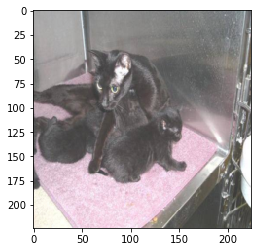

In [6]:
imshow(valid[772][0])

In [7]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=True)

## Transfer learning using VGG

In [8]:
vgg = models.vgg16(pretrained=True)


### Print VGG

In [9]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Freeze layers

In [10]:
vgg.classifier[6].out_features = 2
for param in vgg.features.parameters(): param.requires_grad = False


In [11]:
optimizer = optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

In [12]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [ ]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

### Adjusting dropout

In [ ]:
for layer in vgg.classifier.children():
    if(type(layer) == nn.Dropout):
        layer.p = 0.2

In [ ]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

### Data augmentation

In [ ]:
train_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.RandomHorizontalFlip()
                                       ,transforms.RandomRotation(0.2)
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder('data/train/',train_transform)
valid = ImageFolder('data/valid/',simple_transform)

In [ ]:
train_data_loader = DataLoader(train,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = DataLoader(valid,batch_size=32,num_workers=3,shuffle=True)

In [ ]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

## Calculating preconvoluted features


In [ ]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()

In [ ]:
features = vgg.features

In [ ]:
for param in features.parameters(): param.requires_grad = False


In [ ]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=False)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=False)

In [ ]:
def preconvfeat(dataset,model):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        if is_cuda:
            inputs , labels = inputs.cuda(),labels.cuda()       
        inputs , labels = Variable(inputs),Variable(labels)
        output = model(inputs)
        conv_features.extend(output.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    
    return (conv_features,labels_list)

In [ ]:
conv_feat_train,labels_train = preconvfeat(train_data_loader,features)

In [ ]:
conv_feat_val,labels_val = preconvfeat(valid_data_loader,features)

In [ ]:
class My_dataset(Dataset):
    def __init__(self,feat,labels):
        self.conv_feat = feat
        self.labels = labels
    
    def __len__(self):
        return len(self.conv_feat)
    
    def __getitem__(self,idx):
        return self.conv_feat[idx],self.labels[idx]

In [ ]:
train_feat_dataset = My_dataset(conv_feat_train,labels_train)
val_feat_dataset = My_dataset(conv_feat_val,labels_val)

In [ ]:
train_feat_loader = DataLoader(train_feat_dataset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dataset,batch_size=64,shuffle=True)

In [ ]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

In [ ]:
train_batches = data_gen(conv_feat_train,labels_train)
val_batches = data_gen(conv_feat_val,labels_val)

In [ ]:
optimizer = optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

In [ ]:
def fit_numpy(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        data = data.view(data.size(0), -1)
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [ ]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit_numpy(epoch,vgg.classifier,train_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit_numpy(epoch,vgg.classifier,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

## Visualizing intermediate CNN layers

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=False)
img,label = next(iter(train_data_loader))

In [ ]:
imshow(img[5])

In [ ]:
img = img[5][None]

In [ ]:
vgg = models.vgg16(pretrained=True).cuda()

In [ ]:
class LayerActivations():
    features=None
    
    def __init__(self,model,layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        self.features = output.cpu().data.numpy()
    
    def remove(self):
        self.hook.remove()
        

conv_out = LayerActivations(vgg.features,0)

o = vgg(Variable(img.cuda()))

conv_out.remove()

In [ ]:
act = conv_out.features

In [ ]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

In [ ]:
vgg

In [ ]:
conv_out = LayerActivations(vgg.features,1)

o = vgg(Variable(img.cuda()))

conv_out.remove()

act = conv_out.features

fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

In [ ]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

In [ ]:
conv_out = LayerActivations(vgg.features,1)

o = vgg(Variable(img.cuda()))

conv_out.remove()

act = conv_out.features

In [ ]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(act[0][i])

## Visualizing weights

In [ ]:
vgg = models.vgg16(pretrained=True).cuda()

In [ ]:
vgg.state_dict().keys()

In [ ]:

cnn_weights = vgg.state_dict()['features.0.weight'].cpu()

In [ ]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,6,i+1,xticks=[],yticks=[])
    imshow(cnn_weights[i])

In [ ]:
cnn_weights.shape
